In [1]:
import json
import csv
from sklearn.model_selection import train_test_split
import spacy
import random
from spacy.training.example import Example
from spacy.training import offsets_to_biluo_tags
import warnings


In [2]:
def load_data(file):
    with open(file,"r",encoding="utf-8")as f:
        data = json.load(f)
    return data



In [3]:
def load_sentences(filepath):

    sentences = []
    tokens = []
    ner_tags = []

    with open(filepath, 'r') as f:
        
        for line in f.readlines():
            
            if (line == ('-DOCSTART- -X- O\n') or line == '\n'):
                if len(tokens) > 0:
                    sentences.append({'tokens': tokens, 'ner_tags': ner_tags})
                    tokens = []
                    ner_tags = []
            else:
                l = line.split(' ')
                tokens.append(l[0])
                ner_tags.append(l[3].strip('\n'))
    
    return sentences

In [4]:
DATA = load_data("/Users/abdullah/Downloads/project-1-at-2023-04-30-18-27-525c20fc.json")
BIO_sentences = load_sentences("/Users/abdullah/Downloads/project-1-at-2023-04-30-09-04-525c20fc.conll")

In [5]:
ner_tags_without_O = []
for t in range(len(BIO_sentences)):
    ner_tags = BIO_sentences[t]["ner_tags"]
    ner_tags_without_O.append([tag for tag in ner_tags if tag != "O"])

In [6]:
WIE_OFT_PRO_TWEET = 0

In [7]:
def B_I_Check(tweet, e ,text, start, end, label):
    entity = text[start:end].strip()
    #if text.startswith(" "):
     #   entity = text[start:end].strip()
      #  start+=1
    #if text.endswith(" "):
     #   entity = text[start:end].strip()
     #   end-=1
    global WIE_OFT_PRO_TWEET
    has_space = any(char.isspace() for char in entity)
    if has_space:
        liste_output = []
        new_start = 0    
        entities = entity.split()
        laenge = len(entities)
        new_start = start
        
        for w in range(laenge):
            #print(e)
            l = len(entities[w])
           # print(ner_tags_without_O[tweet][e])
            #print(entities[w],"  ",ner_tags_without_O[tweet][e+w+WIE_OFT_PRO_TWEET])


            liste_output.append((new_start,new_start+l,ner_tags_without_O[tweet][e+w+WIE_OFT_PRO_TWEET]))
            #ner_tags_without_O[tweet].pop(w)
            new_start+=(l+1)  
        WIE_OFT_PRO_TWEET+=w    
        return liste_output
    else:
       # if label != "" and e < len(ner_tags_without_O[tweet]):
        #    lbl = ner_tags_without_O[tweet][e]
         #   return[(start, end,lbl)]
        #elif e > len(ner_tags_without_O[tweet]):
            lbl = str(label[0])
            return[(start, end, "B-"+lbl)]
        
        #else:
        #    return [()]
        
        




In [8]:
MIX_DATA = []
keys =["start","end","labels"]

for zeile in range (len(DATA)):
    Anzahl_entities = len(DATA[zeile]["annotations"][0]["result"])
    text = DATA[zeile]["data"]["text"]
    DATA[zeile]["annotations"][0]["result"] = sorted(DATA[zeile]["annotations"][0]["result"], key=lambda x: x['value']['end'])
    dic_entities = {"entities":[]}
    for i in range(Anzahl_entities):
        
        start = DATA[zeile]["annotations"][0]["result"][i]["value"][keys[0]]
        end = DATA[zeile]["annotations"][0]["result"][i]["value"][keys[1]]
        label = DATA[zeile]["annotations"][0]["result"][i]["value"][keys[2]]

        ergebnis = B_I_Check(zeile,i,text,start,end,label)
        for e in ergebnis:
            dic_entities["entities"].append(e)
    WIE_OFT_PRO_TWEET = 0
    MIX_DATA.append((text,dic_entities))
    

In [9]:
i = 0
for _, annotations in MIX_DATA:
    i+=1
    for ent in annotations.get("entities"):
        if ent[0] == 145 and ent[1] == 150:
            del MIX_DATA[i-1][1]["entities"][4]
            break



In [10]:
i = 0
for _, annotations in MIX_DATA:
    i+=1
    for ent in annotations.get("entities"):
        if ent[2] == "B-geo.":
            print(i)


    
        

38


In [11]:
newgeo =  list(MIX_DATA[37][1]["entities"][3])
newgeo[2] =  "I-Verein"
MIX_DATA[37][1]["entities"][3] = tuple(newgeo)

In [12]:
MIX_DATA[1]

('Today we look at striker Robert Lewandowski who plays for FC Barcelona. What do you think of this player?',
 {'entities': [(25, 31, 'B-SpName'),
   (32, 43, 'I-SpName'),
   (58, 60, 'B-Verein'),
   (61, 70, 'I-Verein')]})

In [13]:
kein_inhalt = [("In my  City, Burger King (@BurgerKingArg) launched an ingenious campaign that successfully resulted in the different ingredients of its burgers trending nationally.", 
                {'entities': []})
]

In [14]:
MIX_DATA.append(kein_inhalt[0])

In [15]:
MIX_DATA[199]

('In my  City, Burger King (@BurgerKingArg) launched an ingenious campaign that successfully resulted in the different ingredients of its burgers trending nationally.',
 {'entities': []})

In [16]:
with open('prepro_DATA.txt', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(MIX_DATA)

In [17]:

# train_data, test_data = train_test_split(MIX_DATA, test_size=0.25, random_state=42,shuffle=True)
# with open('prepro_DATA_test.txt', 'w', newline='') as file:
#     writer = csv.writer(file)
#     writer.writerow(test_data)

### Training


In [18]:
# Load the existing spaCy model
nlp = spacy.load("en_core_web_sm")

# Load the data
# Assume MIX_DATA is already defined


#optimizer = nlp.resume_training()
#optimizer.learn_rate = 0.001


train_data, test_data = train_test_split(MIX_DATA, test_size=0.25, random_state=42,shuffle=True)

# Add the labels to the NER pipeline
ner = nlp.get_pipe("ner")

for _, annotations in train_data:
    for ent in annotations.get("entities"):
        ner.add_label(ent[2])

n_iter = 15

losses_tr = []

# Train the NER model
for i in range(n_iter):
    losses = {}
    random.shuffle(train_data)
    for text, annotations in train_data:
        doc = nlp.make_doc(text)
        gold_biluo_tags = offsets_to_biluo_tags(doc, annotations.get("entities"))
        example = Example.from_dict(doc, {"entities": gold_biluo_tags})
    

        nlp.update([example], losses=losses)
    losses_tr.append(losses["ner"])
    print(f"Iteration {i+1}: loss = {losses['ner']}")


# Evaluate on the test set
tp, fp, fn = 0, 0, 0
for text, annotations in test_data:
    doc = nlp(text)
    predicted_entities = [(ent.start_char, ent.end_char, ent.label_) for ent in doc.ents]
    gold_entities = annotations.get("entities")
    gold_biluo_tags = offsets_to_biluo_tags(doc, gold_entities)
    predicted_biluo_tags = offsets_to_biluo_tags(doc, predicted_entities)
    for tag in predicted_biluo_tags:
        if tag in gold_biluo_tags:
            tp += 1
        else:
            fp += 1
    for tag in gold_biluo_tags:
        if tag not in predicted_biluo_tags:
            fn += 1

precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * precision * recall / (precision + recall)

print(f"Test results: Precision = {precision:.3f}, Recall = {recall:.3f}, F1-score = {f1_score:.3f}")


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "It’s 30 Premier League goals for Erling Haaland on..." with entities "[(32, 38, 'B-SpName'), (39, 46, 'I-SpName'), (71, ...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "UCL: SCHALKE 1(RAUL) - 1 INTER (THIAGO MOTTA); TOT..." with entities "[(5, 12, 'B-Verein'), (15, 19, 'B-SpName'), (25, 3...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/Library/Frameworks/Python.framework/Ver

Iteration 1: loss = 812.6621723553903
Iteration 2: loss = 364.56158344435175
Iteration 3: loss = 140.09975962568157
Iteration 4: loss = 65.43358001909591
Iteration 5: loss = 45.974087189328415
Iteration 6: loss = 82.15008858570265
Iteration 7: loss = 41.263448034307714
Iteration 8: loss = 67.90642219462
Iteration 9: loss = 49.658053553190065
Iteration 10: loss = 10.965375170008238
Iteration 11: loss = 8.157276572762154
Iteration 12: loss = 7.716251971323827
Iteration 13: loss = 7.647075555477592
Iteration 14: loss = 56.50125249999411
Iteration 15: loss = 25.54671304610875
Test results: Precision = 0.985, Recall = 0.984, F1-score = 0.985


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Italian legend Roberto Baggio once refused to take..." with entities "[(0, 7, 'B-Nation'), (15, 22, 'B-SpName'), (23, 29...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


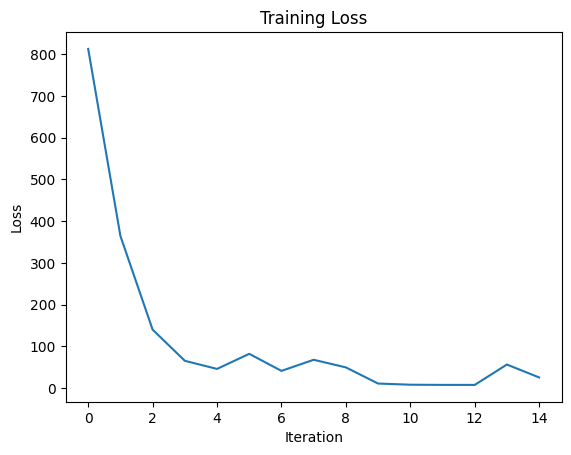

In [19]:
import matplotlib.pyplot as plt

plt.plot(losses_tr)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

In [20]:
nlp.to_disk("NER_Modell")

In [21]:

doc = nlp("Thomas Tuchel didn't have to do him like that")

In [22]:
for ent in doc.ents:
    print(ent.text, ent.label_)

Thomas B-TrName
Tuchel I-TrName


### Data Analyse 

In [23]:
# Laden Sie die Daten aus Ihrem NER-Datensatz
data = MIX_DATA
# Hier sollten Ihre Daten im Format [(Text, {"entities": [(Start, End, Label), (Start, End, Label), ...]}), ...] vorliegen.

# Erstellen Sie eine leere Entitätenliste und eine leere Entitätenanzahl-Dict
entities_list = []
entities_count = {}

# Iterieren Sie durch jeden Text im Datensatz
for text, annotations in data:
    # Verarbeiten Sie den Text mit Spacy
    doc = nlp(text)
    # Iterieren Sie durch jede Entität im Text und fügen Sie sie der Entitätenliste hinzu
    for ent in doc.ents:
        entities_list.append(ent.label_)
        # Fügen Sie die Anzahl der Entität zum Entitätenanzahl-Dict hinzu
        if ent.label_ in entities_count:
            entities_count[ent.label_] += 1
        else:
            entities_count[ent.label_] = 1

# Drucken Sie die Anzahl und Häufigkeit jeder Entität in der Entitätenanzahl-Dict
print("Anzahl der Entitäten insgesamt:", len(entities_list))
print("Entitätenanzahl-Dict:", entities_count)

# Finden Sie die am häufigsten vorkommende Entität
most_common_entity = max(entities_count, key=entities_count.get)
print("Die am häufigsten vorkommende Entität ist:", most_common_entity)


Anzahl der Entitäten insgesamt: 937
Entitätenanzahl-Dict: {'B-Time': 9, 'B-Verein': 275, 'B-SpName': 260, 'I-SpName': 97, 'I-Verein': 61, 'B-TrName': 65, 'I-TrName': 29, 'B-Stadion': 32, 'I-Time': 1, 'B-Date': 35, 'I-Date': 10, 'B-geo. Ort': 22, 'B-Nation': 21, 'I-Stadion': 20}
Die am häufigsten vorkommende Entität ist: B-Verein


In [24]:
# Laden Sie die Daten aus Ihrem NER-Datensatz
data = MIX_DATA
# Hier sollten Ihre Daten im Format [(Text, {"entities": [(Start, End, Label), (Start, End, Label), ...]}), ...] vorliegen.

# Erstellen Sie eine leere Entitätenliste und eine leere Entitätenanzahl-Dict
entities_list = []
entities_count = {}

# Iterieren Sie durch jeden Text im Datensatz
for text, annotations in data:
    # Teilen Sie den Text in Wörter auf
    words = text.split()
    # Iterieren Sie durch jede Entität im Text und fügen Sie sie der Entitätenliste hinzu
    for start, end, label in annotations.get("entities"):
        entity = text[start:end]
        entities_list.append(label)
        # Fügen Sie die Anzahl der Entität zum Entitätenanzahl-Dict hinzu
        if label in entities_count:
            entities_count[label] += 1
        else:
            entities_count[label] = 1

# Drucken Sie die Anzahl und Häufigkeit jeder Entität in der Entitätenanzahl-Dict
print("Anzahl der Entitäten insgesamt:", len(entities_list))
print("Entitätenanzahl-Dict:", entities_count)

# # Finden Sie die am häufigsten vorkommende Entität
# most_common_entity = max(entities_count, key=entities_count.get)
# print("Die am häufigsten vorkommenden Entitäten sind:")
# for entity, count in entities_count.items():
#     if count == entities_count[most_common_entity]:
#         print(entity, "-", count)


ent_val = {}

ent_val["Verein"] = entities_count["B-Verein"] +  entities_count["I-Verein"]
ent_val["SpName"] = entities_count["B-SpName"] +  entities_count["I-SpName"]
ent_val["Time"] = entities_count["B-Time"] +  entities_count["I-Time"]
ent_val["TrName"] = entities_count["B-TrName"] +  entities_count["I-TrName"]
ent_val["Stadion"] = entities_count["B-Stadion"] +  entities_count["I-Stadion"]
ent_val["Date"] = entities_count["B-Date"] +  entities_count["I-Date"]
ent_val["geo. Ort"] = entities_count["B-geo. Ort"] 
ent_val["Nation"] = entities_count["B-Nation"]



ent_val = dict(sorted(ent_val.items(), key=lambda item: item[1], reverse=True))

most_common_entity = max(ent_val, key=ent_val.get)

print("#############################")
for entity, count in ent_val.items():
        print(entity, "-", count)


print("#############################")

for entity, count in ent_val.items():
    if count == ent_val[most_common_entity]:
        print("Am Häufigsten ist: ",entity, "-", count)



Anzahl der Entitäten insgesamt: 929
Entitätenanzahl-Dict: {'B-Time': 8, 'B-Verein': 266, 'B-SpName': 245, 'I-SpName': 92, 'I-Verein': 64, 'B-TrName': 78, 'I-TrName': 32, 'B-Stadion': 34, 'I-Time': 1, 'B-Date': 32, 'I-Date': 12, 'B-geo. Ort': 27, 'B-Nation': 19, 'I-Stadion': 19}
#############################
SpName - 337
Verein - 330
TrName - 110
Stadion - 53
Date - 44
geo. Ort - 27
Nation - 19
Time - 9
#############################
Am Häufigsten ist:  SpName - 337


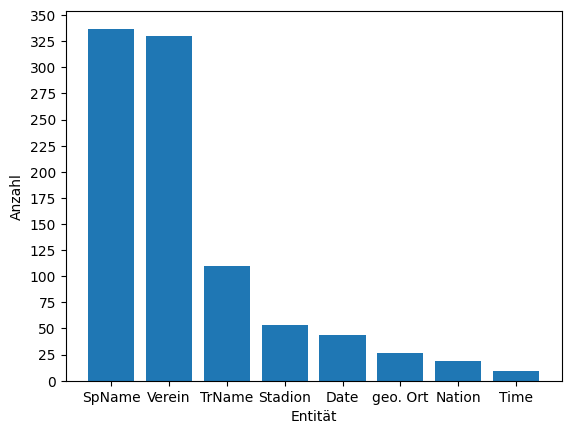

In [25]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.bar(ent_val.keys(), ent_val.values())
ax.set_xlabel("Entität")
ax.set_ylabel("Anzahl")
ax.set_yticks(range(0, 355, 25))
plt.show()



In [26]:
import pandas as pd
# Laden Sie die Daten aus Ihrem NER-Datensatz
data = MIX_DATA
# Hier sollten Ihre Daten im Format [(Text, {"entities": [(Start, End, Label), (Start, End, Label), ...]}), ...] vorliegen.

# Erstellen Sie ein leeres Dictionary, um die Häufigkeit jedes Wertes für jede Entität zu zählen
entity_values_count = {}

# Iterieren Sie durch jeden Text im Datensatz
for text, annotations in data:
    # Iterieren Sie durch jede Entität im Text
    for ent in annotations.get("entities"):
        entity_label = ent[2]
        entity_value = text[ent[0]:ent[1]]
        # Fügen Sie den Wert zur Häufigkeitszählung hinzu
        if entity_label not in entity_values_count:
            entity_values_count[entity_label] = {}
        if entity_value not in entity_values_count[entity_label]:
            entity_values_count[entity_label][entity_value] = 1
        else:
            entity_values_count[entity_label][entity_value] += 1


# Iterieren Sie durch jede Entität und geben Sie die Top 3 der häufigsten Werte aus
# for entity_label in entity_values_count:
#     if entity_label != "B-Time" and entity_label != "I-Time" and entity_label !="B-Date" and entity_label !="I-Date":
#         print("Häufigste Werte für", entity_label)
#         values_count = entity_values_count[entity_label]
#         sorted_values = sorted(values_count.items(), key=lambda item: item[1], reverse=True)
#         for value, count in sorted_values[:3]:
#             print(value, "-", count)
# Iterieren Sie durch jede Entität und geben Sie die Top 3 der häufigsten Werte aus

entity_table = {}
for entity_label in entity_values_count:
    if entity_label != "B-Time" and entity_label != "I-Time" and entity_label !="B-Date" and entity_label !="I-Date":
        #print("Häufigste Werte für", entity_label)
        values_count = entity_values_count[entity_label]
        sorted_values = sorted(values_count.items(), key=lambda item: item[1], reverse=True)
        for value, count in sorted_values[:3]:
            #print(value, "-", count)
            if entity_label not in entity_table:
                entity_table[entity_label] = {"value":[value], "count":[count]}
            else:
                entity_table[entity_label]["value"].append(value)
                entity_table[entity_label]["count"].append(count)

# Erstellen Sie das DataFrame-Objekt und speichern Sie es in einer CSV-Datei
for entity_label in entity_table:
    print(entity_label)
    df = pd.DataFrame(entity_table[entity_label])
    print(df)

B-Verein
     value  count
0     Real     29
1  Chelsea     22
2  Arsenal     18
B-SpName
       value  count
0      Messi      9
1  Cristiano      8
2    Ronaldo      8
I-SpName
     value  count
0   Hazard      5
1  Ronaldo      5
2     Bale      3
I-Verein
    value  count
0  Madrid     28
1  United      8
2   Milan      4
B-TrName
        value  count
0  Nagelsmann      8
1      Julian      5
2        Jose      5
I-TrName
        value  count
0  Nagelsmann      4
1    Mourinho      4
2      Tuchel      3
B-Stadion
     value  count
0      Old      7
1  Allianz      6
2  Anfield      4
B-geo. Ort
     value  count
0  England      4
1    Paris      2
2   Munich      2
B-Nation
     value  count
0  English      4
1   French      4
2  Spanish      2
I-Stadion
      value  count
0  Trafford      7
1     Arena      6
2       Nou      1


In [27]:
entity_table = {}
for entity_label in entity_values_count:
    values_count = entity_values_count[entity_label]
    sorted_values = sorted(values_count.items(), key=lambda item: item[1], reverse=True)
    for i, (value, count) in enumerate(sorted_values[:3]):
        if entity_label not in entity_table:
            entity_table[entity_label] = {}
        entity_table[entity_label][f"Top {i+1} value"] = value
        entity_table[entity_label][f"Top {i+1} count"] = count

# Erstellen Sie das DataFrame-Objekt und speichern Sie es in einer CSV-Datei
df = pd.DataFrame(entity_table).T
df.index.name = "Entity Label"
df.to_csv("entity_counts.csv")